In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import openpyxl
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use("seaborn-bright")
plt.style.use("bmh")

## Неделя 1

### Парсинг данных долговых обязательств, в том числе просроченных

#### Данные с 2019 по 2021 года

In [2]:
# Открываем требуемую страницу необходимого файла
work_book = openpyxl.load_workbook('Debt_individuals_02.2019_10.2021.xlsx', read_only=True)
work_sheet = work_book["итого"]

# Получаем доступ к необходимым ячейкам
date_cells = work_sheet['B2':'AH2'][0]
debt_cells = work_sheet['B3':'AH3'][0]

# Считываем данные (полный объем задолжностей в определенный период времени) из этих ячеек
dates = [date.value for date in date_cells]
debts = [debt.value for debt in debt_cells]

# Открываем другую страницу того же excel-файла
work_sheet = work_book["в т.ч.просроч."]

# Считываем необходимые данные (объем просроченных задолжностей)
overdue_debt_cells = work_sheet['B3':'AH3'][0]
overdue_debts = [overdue_debt.value for overdue_debt in overdue_debt_cells]

# Закрываем excel-файл
work_book.close()

In [3]:
# Создаем DataFrame на основе считанных ранее данных
data_2019_2021 = pd.DataFrame({'Total Debt': debts, 'Total Overdue Debt': overdue_debts},
                              dtype=int, index=dates)

data_2019_2021.index.name = 'Date'
data_2019_2021.index = pd.to_datetime(data_2019_2021.index, dayfirst=True)
data_2019_2021.index = data_2019_2021.index.to_period(freq='m')

data_2019_2021.head()

,Total Debt,Total Overdue Debt
Date,,
2019-02,13021961,594947
2019-03,13206591,600027
2019-04,13523405,605436
2019-05,13806875,614989
2019-06,14037095,622826


#### Данные с 2009 по 2019 года

In [4]:
# Открываем excel-файл
work_book = openpyxl.load_workbook('Debt_individuals_04.2009_01.2019.xlsx', read_only=True)

# Делаем шаблон DataFrame, к которому будут аппендиться считываемые данные
data_2009_2019 = pd.DataFrame({'Total Debt': [], 'Total Overdue Debt': []}, dtype=int, index=[])

# # Для каждого листа excel-файла считываем данные полной и просроченной задолжностей
# for sheet in work_book:
#     data_to_append = pd.DataFrame({'Total Debt': sheet['B7'].value,
#                                    'Total Overdue Debt': sheet['H7'].value},
#                                   index=[sheet.title.split(' ')[2]], dtype=int)


for sheet in work_book:
    
    term = pd.to_datetime(sheet.title.split(' ')[2], dayfirst=True)
    
    if term <= pd.to_datetime('01.11.2010', dayfirst=True):
        data_to_append = pd.DataFrame({'Total Debt': sheet['E7'].value,
                               'Total Overdue Debt': sheet['H7'].value},
                              index=[term], dtype=int)
    else:
        data_to_append = pd.DataFrame({'Total Debt': sheet['E8'].value,
                       'Total Overdue Debt': sheet['H8'].value},
                      index=[term], dtype=int)
        
    data_2009_2019 = data_2009_2019.append(data_to_append)

    
# Закрываем excel-файл
work_book.close()

# Переставляем строки задом наперед и работаем с индексами строк
data_2009_2019 = data_2009_2019.iloc[::-1]
data_2009_2019.index.name = 'Date'
data_2009_2019.index = pd.to_datetime(data_2009_2019.index, dayfirst=True)
data_2009_2019.index = data_2009_2019.index.to_period(freq='m')

data_2009_2019.head()

,Total Debt,Total Overdue Debt
Date,,
2009-04,3848399,180597
2009-05,3791289,193421
2009-06,3722873,202671
2009-07,3683033,209446
2009-08,3667260,217713


#### Общие данные с 2009 по 2021 года

In [5]:
# Объединяем данные разных лет. До сих рассматривались месячные задолжности 
monthly_debt_data = pd.concat([data_2009_2019, data_2019_2021])

# Рассчитываем уровень просроченной задолжности как отношение суммы просроченной задолжности к общей задолжности
monthly_debt_data['Level of Overdue'] = 100 * monthly_debt_data['Total Overdue Debt'] / monthly_debt_data['Total Debt']

# Переходим к квартальным задолжностям
quarterly_debt_data = monthly_debt_data.iloc[2::3]

quarterly_debt_data.head()

,Total Debt,Total Overdue Debt,Level of Overdue
Date,,,
2009-06,3722873,202671,5.443941
2009-09,3645774,226049,6.200302
2009-12,3571803,241050,6.748692
2010-03,3511761,255788,7.283753
2010-06,3596957,268975,7.477849


#### Визуализация спарсенных данных

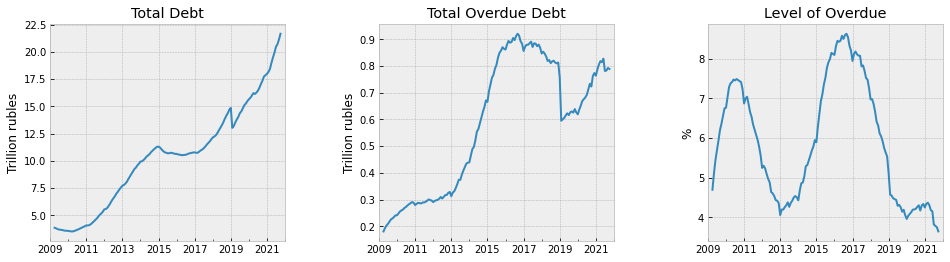

In [6]:
fig = plt.figure(figsize=(16,4))

plt.subplots_adjust(wspace=0.4, hspace=0.5)

plt.subplot(1, 3, 1)
(monthly_debt_data['Total Debt'] / 10**6).plot()
plt.xlabel('')
plt.xlim([pd.Period('2009-01'), pd.Period('2022-01')])
plt.ylabel('Trillion rubles')
plt.title('Total Debt')

plt.subplot(1, 3, 2)
(monthly_debt_data['Total Overdue Debt'] / 10**6).plot()
plt.xlabel('')
plt.xlim([pd.Period('2009-01'), pd.Period('2022-01')])
plt.ylabel('Trillion rubles')
plt.title('Total Overdue Debt')

plt.subplot(1, 3, 3)
monthly_debt_data['Level of Overdue'].plot()
plt.xlabel('')
plt.xlim([pd.Period('2009-01'), pd.Period('2022-01')])
plt.ylabel('%')
plt.title('Level of Overdue')

plt.show()

### Исторические данные и прогнозы

В качестве макроэкономических показателей рассмотрены:
- Валовой внутренний продукт
- Валютный курс USDRUB
- Индекс потребительских цен
- Оборот розничной торговли
- Уровень безработицы

#### Валовой внутренний продукт

Источник исторических данных: https://rosstat.gov.ru/storage/mediabank/VVP_kvartal_s_1995.xls 

Источник прогнозируемых значений: https://www.economy.gov.ru/material/file/3007f2d6805edf0b5a5c391db1a87b8b/Attachments.zip 

In [7]:
# Исторические данные ВВП представлены в excel-файле на двух листах
work_book = openpyxl.load_workbook('Data\GDP_historical_data.xlsx', read_only=True)

# Считываем данные первого листа (до 2012г.)
work_sheet = work_book["1"]
gdp_cells_1 = work_sheet['BF5':'BP5'][0]
gdps_1 = [gdp.value for gdp in gdp_cells_1]

# Считываем данные второго листа (с 2012г.)
work_sheet = work_book["2"]
gdp_cells_2 = work_sheet['E5':'AP5'][0]
gdps_2 = [gdp.value for gdp in gdp_cells_2]

# Объединяем данные (np.nan ввиду отсутсвия отчетных данных по ВВП третьего квартала текущего года)
gdps = gdps_1 + gdps_2 + [np.nan]

# Закрываем excel-файл
work_book.close()

# На основе считанных данных создаем DataFrame
GDP_historical_data = pd.DataFrame(data=gdps, columns=['GDP'],
                                   index=[pd.Period('2009-06') + 3*months for months in range(len(gdps))])

# ВВП в триллионах руб.
GDP_historical_data /= 10**3

# Данные по ВВП квартальные
GDP_historical_data.head()

,GDP
2009-06,9.244829
2009-09,10.411334
2009-12,10.816423
2010-03,9.995758
2010-06,10.977035


Далее рассматриваем кумулятивное представление ВВП, т.е. значение ВВП в определенный квартал отражает рыночную стоимость всех товаров и услуг произведенных в течение года до конца данного квартала, а не в течении только трех месяцев данного квартала.

In [8]:
cumulative_historical_GDP = GDP_historical_data.copy()

# Рассчитываем ВВП с "нарастающим итогом"
for i, date in enumerate(GDP_historical_data.index):
    if date.month != 3 and i!=0:
        cumulative_historical_GDP.GDP[i] = GDP_historical_data.GDP[i] + cumulative_historical_GDP.GDP[i-1]
    else:
        cumulative_historical_GDP.GDP[i] = GDP_historical_data.GDP[i]
            
cumulative_historical_GDP.head()

,GDP
2009-06,9.244829
2009-09,19.656163
2009-12,30.472586
2010-03,9.995758
2010-06,20.972794


In [9]:
# DataFrame шаблон для предсказанных значений ВВП 
GDP_forecast = pd.DataFrame(data=[np.nan]*5, columns=['GDP'],
                            index=[pd.Period('2021-12') + 3*months for months in range(5)])

# Открываем excel-файл, считываем необходимые прогнозные данные по ВВП, закрываем excel-файл
work_book = openpyxl.load_workbook('Data\Macro_forecast_2.xlsx', read_only=True)

work_sheet = work_book["Макро Выход"]

GDP_forecast.GDP['2021-12'] = work_sheet['D13'].value
GDP_forecast.GDP['2022-12'] = work_sheet['E13'].value

work_book.close()

# ВВП в триллионах руб.
GDP_forecast /= 10**3

GDP_forecast.head()

,GDP
2021-12,119.426347
2022-03,NaN
2022-06,NaN
2022-09,NaN
2022-12,126.736025


In [10]:
def interpolator(historical_data, forecast, p=4, d=1, q=3):
    '''
    Данная функция осуществляет сезонную интерполяцию данных
    
    historical_data - исторические данные макропоказателя
    forecast - прогнозные значения макропоказателя
    
    Функция возвращает DataFrame интерполированных данных,
    трендовую составляющую интерполированных данных,
    а также сезонную составляющую интерполированных данных
    '''
    
    # Объединение исторических и прогнозных данных
    data = pd.concat([historical_data, forecast])
    
    # Работа с индексами
    historical_data.index = historical_data.index.to_timestamp()
    forecast.index = forecast.index.to_timestamp()
    data.index = data.index.to_timestamp()
    
    # Трендовая составляющая исторических данных оценивается как скользящая средняя с периодом в один год;
    # Сезонная составляющая исторических данных получается вычетанием оценки тренда из общих данных
    seasonal_component_historical_simulation = (historical_data - historical_data.rolling(window=4).mean()).dropna()
    
    # С помощи модели ARIMA осуществляется прогноз сезонной составляющей до конца 2022 года
    model = ARIMA(seasonal_component_historical_simulation, order=(p, d, q))
    model_fit = model.fit()

    seasonal_component_forecast = model_fit.predict(len(seasonal_component_historical_simulation),
                                                    len(seasonal_component_historical_simulation)+5, typ='levels')
    
    # Полная сезонная составляющая
    seasonal_component_forecast = seasonal_component_forecast.to_frame(name=historical_data.columns[0])
    seasonal_component = pd.concat([seasonal_component_historical_simulation, seasonal_component_forecast])
    
    # Полная трендовая составляющая
    trend = data - seasonal_component
    
    # Интерполяция трендовой составляющей (сезонная уже известна)
    treand_interpolation = trend.interpolate('cubic')

    # Интерполированные данные получаются сложением тренда и сезонной составляющей
    data_interpolation = seasonal_component + treand_interpolation
    data_interpolation[data_interpolation.isna().iloc[:, 0]] = historical_data[data_interpolation.isna().iloc[:, 0]]
    data_interpolation = data_interpolation.dropna()
    treand_interpolation = treand_interpolation.dropna()
    seasonal_component = seasonal_component.dropna()
    
    data_interpolation.index = data_interpolation.index.to_period(freq='m') + 2
    treand_interpolation.index = treand_interpolation.index.to_period(freq='m') + 2
    seasonal_component.index = seasonal_component.index.to_period(freq='m') + 2
    
    return data_interpolation, treand_interpolation, seasonal_component

In [11]:
# Интерполяция данных по ВВП

is_GDP_cumulative = True
if is_GDP_cumulative:
    GDP_historical_data = cumulative_historical_GDP
    
GDP_data_interpolation, _, _ = interpolator(GDP_historical_data, GDP_forecast)

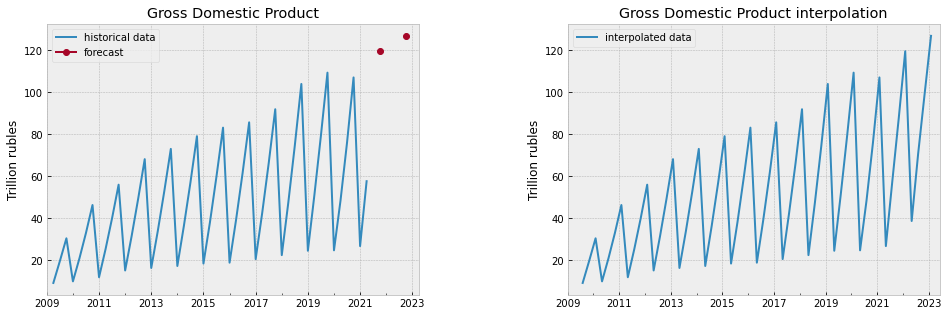

In [12]:
# Визуализация данных

fig = plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
GDP_historical_data['GDP'].plot()
GDP_forecast['GDP'].plot(marker='o')
plt.xlim([pd.Period('2009-01'), pd.Period('2023-06')])
plt.xlabel('')
plt.ylabel('Trillion rubles')
plt.legend(['historical data', 'forecast'])
plt.title('Gross Domestic Product')

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.subplot(1, 2, 2)
GDP_data_interpolation['GDP'].plot()
plt.xlim([pd.Period('2009-01'), pd.Period('2023-06')])
plt.xlabel('')
plt.ylabel('Trillion rubles')
plt.legend(['interpolated data'])
plt.title('Gross Domestic Product interpolation')

plt.show()

#### Валютный курс USDRUB

Источник исторических данных: https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=2&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.From=01.01.2009&UniDbQuery.To=01.10.2021 

Источник прогнозируемых значений: https://www.economy.gov.ru/material/file/3007f2d6805edf0b5a5c391db1a87b8b/Attachments.zip 

In [13]:
# Считываем необходимые данные
exchange_rates = pd.read_excel(r'Data\USDRUB_historical_data.xlsx', index_col=1).iloc[:, 1].to_frame(name='USDRUB')[::-1]

exchange_rates.index = exchange_rates.index.to_period(freq='d')
exchange_rates.index.name = 'Date'

# На данный момент валютные курсы ежедневные
exchange_rates.tail()

,USDRUB
Date,
2021-09-25,73.0081
2021-09-28,72.6613
2021-09-29,72.5083
2021-09-30,72.7608
2021-10-01,72.6642


In [14]:
# Лист для хранения среднемесячных валютных курсов
monthly_exchange_rates = []

# Расчет среднемесячных валютных курсов
for year in range(2009, 2022):
    for month in range(1, 13):
        if pd.Period(year=year, month=month, freq='m') <= pd.Period(year=2021, month=10, freq='m') :
            
            last_day_of_month = \
            exchange_rates.index[(exchange_rates.index.year == year) & (exchange_rates.index.month == month)].max()
            
            monthly_exchange_rates.append(exchange_rates.loc[last_day_of_month, 'USDRUB'])

# Избавляемся от лишних данных (первый квартал 2009г.)
monthly_exchange_rates = monthly_exchange_rates[3:]     
        
# Переносим данные в DataFrame
exchange_rates_historical_data = pd.DataFrame(data=monthly_exchange_rates, columns=['USDRUB'],
                                              index=[pd.Period('2009-04') + months for months in range(len(monthly_exchange_rates))])

# Переходим к квартальным данным
exchange_rates_historical_data = exchange_rates_historical_data.iloc[2::3]
exchange_rates_historical_data.index.name = 'Date'

exchange_rates_historical_data.head()

,USDRUB
Date,
2009-06,31.2904
2009-09,30.0922
2009-12,30.2442
2010-03,29.3638
2010-06,31.1954


In [15]:
# DataFrame шаблон для прогнозируемых значений курса USDRUB
exchange_rates_forecast = pd.DataFrame(data=[np.nan]*5, columns=['USDRUB'],
                                       index=[pd.Period('2021-12') + 3*months for months in range(5)])

exchange_rates_forecast.index.name = 'Date'

# Считываем необходимые данные
work_book = openpyxl.load_workbook('Data\Macro_forecast_1.xlsx', read_only=True)

work_sheet = work_book["Condition_отправка"]

exchange_rates_forecast.USDRUB['2021-12'] = work_sheet['D34'].value
exchange_rates_forecast.USDRUB['2022-12'] = work_sheet['E34'].value

work_book.close()

exchange_rates_forecast

,USDRUB
Date,
2021-12,73.2790
2022-03,NaN
2022-06,NaN
2022-09,NaN
2022-12,71.7667


In [16]:
# Интерполяция данных о валютном курсе

exchange_rates_interpolation, _, _ = interpolator(exchange_rates_historical_data, exchange_rates_forecast)

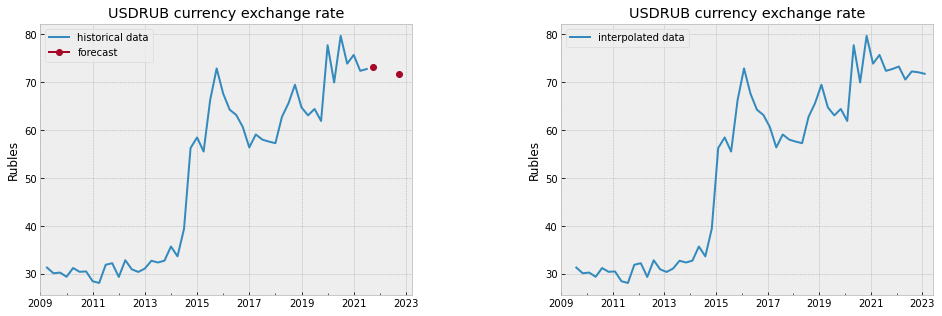

In [17]:
# Визуализация данных

fig = plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
exchange_rates_historical_data['USDRUB'].plot()
exchange_rates_forecast['USDRUB'].plot(marker='o')
plt.xlim([pd.Period('2009-01'), pd.Period('2023-06')])
plt.xlabel('')
plt.ylabel('Rubles')
plt.legend(['historical data', 'forecast'])
plt.title('USDRUB currency exchange rate')

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.subplot(1, 2, 2)
exchange_rates_interpolation['USDRUB'].plot()
plt.xlim([pd.Period('2009-01'), pd.Period('2023-06')])
plt.xlabel('')
plt.ylabel('Rubles')
plt.legend(['interpolated data'])
plt.title('USDRUB currency exchange rate')

plt.show()

#### Индекс потребительских цен

Источник исторических данных: https://rosstat.gov.ru/storage/mediabank/i_ipc-1991-2021.xlsx 

Источник прогнозируемых значений: https://www.economy.gov.ru/material/file/3007f2d6805edf0b5a5c391db1a87b8b/Attachments.zip , а также https://cbr.ru/statistics/ddkp/mo_br/

In [18]:
# Открываем необходимый excel-файл
work_book = openpyxl.load_workbook('Data\CPI_historical_data.xlsx', read_only=True)
work_sheet = work_book["ИПЦ"]

cell_range = work_sheet['T6':'AF17']

# Последовательно получаем доступ к каждой требуемой ячейке и считываем из них данные
ips = []
for row in range(len(cell_range[0])):
    for column in cell_range:
        ips.append(column[row].value)

# Переводим данные в DataFrame
CPI_historical_data = pd.DataFrame(data=ips, columns=['CPI'],
                                   index=[pd.Period('2009-01') + months for months in range(len(ips))])

# Переходим от % к абсолютным значениям
CPI_historical_data /= 100
CPI_historical_data.index.name = 'Date'

work_book.close()

CPI_historical_data.head()

,CPI
Date,
2009-01,1.0237
2009-02,1.0165
2009-03,1.0131
2009-04,1.0069
2009-05,1.0057


Представленные данные указывают прирост показателя ИПЦ относительно предыдущего периода (предыдущего месяца). Для перехода к квартальным значениям необходимо перемножить все входящие в этот квартал индексы, характеризующие изменение цен в отчетном периоде по сравнению с предыдущим. Так, например, индекс потребительских цен за период январь 2020 г. - апрель 2020 г. рассчитывается следующим образом: 

$ 100,40\% * \frac{100,33\%}{100\%} * \frac{100,55\%}{100\%} * \frac{100,83\%}{100\%} = 102,13\% $

In [19]:
cumulative_historical_CPI = CPI_historical_data.copy()

# Расчет кумулятивного ежемесячного показателя ИПЦ
for i, date in enumerate(CPI_historical_data.index):
    if date.month != 1 and i!=0:
        cumulative_historical_CPI.CPI[i] = CPI_historical_data.CPI[i] * cumulative_historical_CPI.CPI[i-1]
    else:
        cumulative_historical_CPI.CPI[i] = CPI_historical_data.CPI[i]

# Переход к ежеквартальным данным
cumulative_historical_CPI = cumulative_historical_CPI.iloc[5:-1:3]

cumulative_historical_CPI.head()

,CPI
Date,
2009-06,1.073953
2009-09,1.080394
2009-12,1.087970
2010-03,1.031599
2010-06,1.043819


In [20]:
# DataFrame шаблон для прогнозируемых значений индекса потребительских цен
CPI_forecast = pd.DataFrame(data=[np.nan]*5, columns=['CPI'],
                            index=[pd.Period('2021-12') + 3*months for months in range(5)])

CPI_forecast.index.name = 'Date'

# Предусмотрена возможность выбора между прогнозами минэкономразвития и ЦБ РФ;
# По умолчанию 'CBRF_forecast = True', т.е. используется более адекватный прогноз ЦБ РФ
CBRF_forecast = True

if CBRF_forecast:
    CPI_forecast.CPI['2021-12'] = 1.07
    CPI_forecast.CPI['2022-12'] = 1.042
else:
    work_book = openpyxl.load_workbook('Data\Macro_forecast_4.xlsx', read_only=True)

    work_sheet = work_book["1.ИПЦ"]

    CPI_forecast.CPI['2021-12'] = work_sheet['C9'].value / 100
    CPI_forecast.CPI['2022-12'] = work_sheet['D9'].value / 100

    work_book.close()

# Данные уже ежеквартальные
CPI_forecast

,CPI
Date,
2021-12,1.070
2022-03,NaN
2022-06,NaN
2022-09,NaN
2022-12,1.042


In [21]:
# Интерполяция данных по индексу потребительских цен

CPI_data_interpolation, _, _ = interpolator(cumulative_historical_CPI, CPI_forecast)

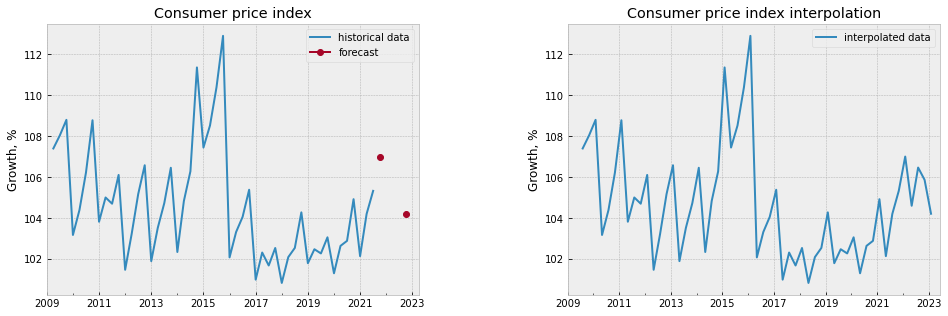

In [22]:
# Визуализация данных

fig = plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
(100 * cumulative_historical_CPI['CPI']).plot()
(100 * CPI_forecast['CPI']).plot(marker='o')
plt.xlim([pd.Period('2009-01'), pd.Period('2023-06')])
plt.xlabel('')
plt.ylabel('Growth, %')
plt.legend(['historical data', 'forecast'])
plt.title('Consumer price index')

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.subplot(1, 2, 2)
(100 * CPI_data_interpolation['CPI']).plot()
plt.xlim([pd.Period('2009-01'), pd.Period('2023-06')])
plt.xlabel('')
plt.ylabel('Growth, %')
plt.legend(['interpolated data'])
plt.title('Consumer price index interpolation')

plt.show()

#### Оборот розничной торговли

Источник исторических данных: https://fedstat.ru/indicator/31260 

Источник прогнозируемых значений: https://www.economy.gov.ru/material/file/3007f2d6805edf0b5a5c391db1a87b8b/Attachments.zip , а также https://cbr.ru/statistics/ddkp/mo_br/

In [23]:
# Считывание максимально криво сконструированных исторических данных
retail_turnover = pd.read_excel(r'Data\Retail_turnover.xlsx', usecols="B:C")[3:]

retail_turnover.columns = ['Period', 'RT']

periods = set(['январь-март', 'январь-июнь', 'январь-сентябрь', 'январь-декабрь', '9 месяцев'])

rt = []
for row, period in enumerate(retail_turnover.Period):
    if period in periods:
        rt.append(retail_turnover.RT.iloc[row])

rt = pd.Series(rt).unique()[1:] / 10**6
        
RT_historical_data = pd.DataFrame(data=rt, columns=['RT'],
                                  index=[pd.Period('2009-06') + 3*months for months in range(len(rt))])

RT_historical_data.index.name = 'Date'

RT_historical_data.head()

,RT
Date,
2009-06,6.843774
2009-09,10.531831
2009-12,14.599153
2010-03,3.633969
2010-06,7.577591


In [24]:
# Считывание данных прогноза оборота розничной торговли
RT_forecast = pd.DataFrame(data=[np.nan]*5, columns=['RT'],
                           index=[pd.Period('2021-12') + months for months in np.arange(0, 15, 3)])

RT_forecast.index.name = 'Date'

work_book = openpyxl.load_workbook('Data\Macro_forecast_2.xlsx', read_only=True)

work_sheet = work_book["Макро Выход"]

RT_forecast.RT['2021-12'] = work_sheet['D28'].value / 1000
RT_forecast.RT['2022-12'] = work_sheet['E28'].value / 1000

work_book.close()

RT_forecast.head()

,RT
Date,
2021-12,37.241218
2022-03,NaN
2022-06,NaN
2022-09,NaN
2022-12,39.739098


In [25]:
# Интерполяция данных по обороту розничной торговли

RT_data_interpolation, _, _ = interpolator(RT_historical_data, RT_forecast)

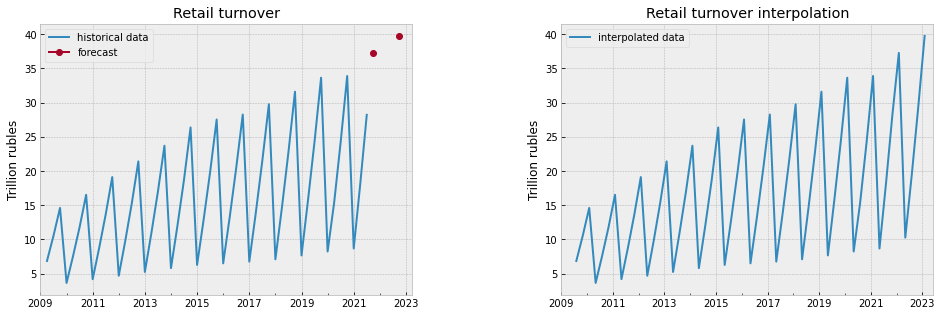

In [26]:
# Визуализация данных

fig = plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
RT_historical_data['RT'].plot()
RT_forecast['RT'].plot(marker='o')
plt.xlim([pd.Period('2009-01'), pd.Period('2023-06')])
plt.xlabel('')
plt.ylabel('Trillion rubles')
plt.legend(['historical data', 'forecast'])
plt.title('Retail turnover')

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.subplot(1, 2, 2)
RT_data_interpolation['RT'].plot()
plt.xlim([pd.Period('2009-01'), pd.Period('2023-06')])
plt.xlabel('')
plt.ylabel('Trillion rubles')
plt.legend(['interpolated data'])
plt.title('Retail turnover interpolation')

plt.show()

#### Уровень безработицы

Источник исторических данных: https://ru.investing.com/economic-calendar/russian-unemployment-rate-556  

Источник прогнозируемых значений: https://www.economy.gov.ru/material/file/3007f2d6805edf0b5a5c391db1a87b8b/Attachments.zip , а также https://cbr.ru/statistics/ddkp/mo_br/

In [27]:
# Считывание месячных исторических данных по уровню безработицы
unemployment_rate = pd.read_excel(r'Data\Unemployment_rate.xlsx', index_col=0, usecols="A,C")[::-1]

# Переход к квартальным данным рассматриваемого периода
unemployment_rate = unemployment_rate[8::3]

# Уровень безработицы далее в %
UR_historical_data = pd.DataFrame(data=100*unemployment_rate.to_numpy(), columns=['UR'],
                                  index=RT_historical_data.index)

UR_historical_data.index = UR_historical_data.index.to_period(freq='m')

UR_historical_data.head()

,UR
Date,
2009-06,8.2
2009-09,7.5
2009-12,8.0
2010-03,8.5
2010-06,6.7


In [28]:
# Считывание данных прогнозируемых значений уровня безработицы
UR_forecast = pd.DataFrame(data=[np.nan]*5, columns=['UR'],
                           index=[pd.Period('2021-12') + 3*months for months in range(5)])

UR_forecast.index.name = 'Date'

work_book = openpyxl.load_workbook('Data\Macro_forecast_2.xlsx', read_only=True)

work_sheet = work_book["Макро Выход"]

UR_forecast.UR['2021-12'] = work_sheet['D100'].value
UR_forecast.UR['2022-12'] = work_sheet['E100'].value

work_book.close()

UR_forecast.head()

,UR
Date,
2021-12,5.1940
2022-03,NaN
2022-06,NaN
2022-09,NaN
2022-12,4.6779


In [29]:
# Интерполяция данных

UR_data_interpolation, _, _ = interpolator(UR_historical_data, UR_forecast, p=2, d=1, q=1)

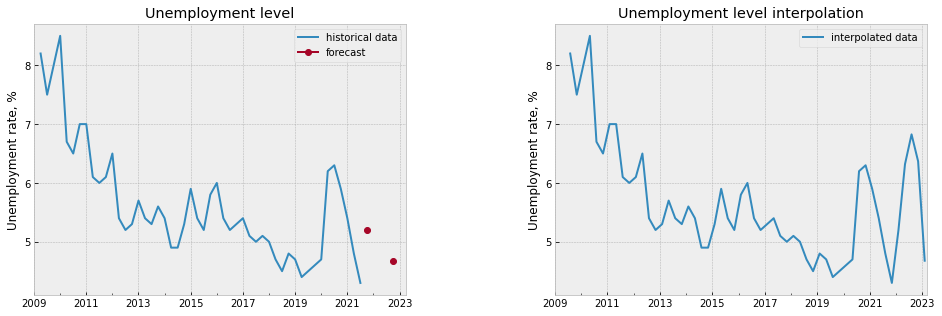

In [30]:
# Визуализация данных

fig = plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
UR_historical_data['UR'].plot()
UR_forecast['UR'].plot(marker='o')
plt.xlim([pd.Period('2009-01'), pd.Period('2023-06')])
plt.xlabel('')
plt.ylabel('Unemployment rate, %')
plt.legend(['historical data', 'forecast'])
plt.title('Unemployment level')

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.subplot(1, 2, 2)
UR_data_interpolation['UR'].plot()
plt.xlim([pd.Period('2009-01'), pd.Period('2023-03')])
plt.xlabel('')
plt.ylabel('Unemployment rate, %')
plt.legend(['interpolated data'])
plt.title('Unemployment level interpolation')

plt.show()

## Неделя 2

In [31]:
# DataFrame интерполированных макропоказателей (резльтат работы прошлой недели)
macroeconomic_indicators = pd.concat([GDP_data_interpolation,
                                      exchange_rates_interpolation,
                                      CPI_data_interpolation,
                                      RT_data_interpolation,
                                      UR_data_interpolation],
                                     axis=1)

macroeconomic_indicators.head()

,GDP,USDRUB,CPI,RT,UR
2009-08,9.244829,31.2904,1.073953,6.843774,8.2
2009-11,19.656163,30.0922,1.080394,10.531831,7.5
2010-02,30.472586,30.2442,1.087970,14.599153,8.0
2010-05,9.995758,29.3638,1.031599,3.633969,8.5
2010-08,20.972794,31.1954,1.043819,7.577591,6.7


### Проверка временных рядов на стационарность

In [32]:
def check_stationarity(time_series, alpha=0.05):
    '''
    time_series - временной ряд, проверяемый на стационарность
    alpha - уровень значимости (по умолчанию 5%)
    
    Функция реализует тест Дики-Фуллера стационарности временного ряда
    Нулевая гипотеза Н0: временной ряд НЕ стационарен
    Альтернативная гипотеза Н1: временной ряд стационарен
    '''
    
    # Проведение теста
    test_results = adfuller(time_series)
    
    p_value = test_results[1]
    
    # Отображение результатов теста
    if p_value < alpha:
        print(f"p-value is {p_value:.4}" + "  =>  The Null hypothesis is rejected")
        print("The time series examined is stationary")
    else:
        print(f"p-value is {p_value:.4}" + "  =>  The Null hypothesis is not rejected")
        print("The time series examined is NOT stationary")

#### Уровень просроченной задолжности

In [33]:
# Проверка временного ряда уровня просроченной задолжности на стационарность
print('Level of overdue time series:')
check_stationarity(quarterly_debt_data['Level of Overdue'])
print('\n')

# Проверка относительных (процентных) изменений уровня просроченной задолжности
print('Level of overdue percentage change time series:')
check_stationarity(quarterly_debt_data['Level of Overdue'].pct_change().dropna())
print('\n')

# Проверка абсолютных изменений уровня просроченной задолжности
print('Level of overdue absolute change time series:')
check_stationarity(quarterly_debt_data['Level of Overdue'].diff().dropna())

# Временной ряд абсолютных изменений уровня просроченной задолжности стационарен
stationary_level_of_overdue = quarterly_debt_data['Level of Overdue'].diff().dropna().to_frame()

stationary_level_of_overdue.head()

Level of overdue time series:
p-value is 0.05023  =>  The Null hypothesis is not rejected
The time series examined is NOT stationary


Level of overdue percentage change time series:
p-value is 0.05886  =>  The Null hypothesis is not rejected
The time series examined is NOT stationary


Level of overdue absolute change time series:
p-value is 0.04604  =>  The Null hypothesis is rejected
The time series examined is stationary


,Level of Overdue
Date,
2009-09,0.756361
2009-12,0.548390
2010-03,0.535061
2010-06,0.194096
2010-09,-0.011434


#### Валовой внутренний продукт

In [34]:
# Проверка временного ряда ВВП на стационарность
print('GDP time series:')
check_stationarity(macroeconomic_indicators['GDP'])
print('\n')

# Проверка относительных (процентных) изменений ВВП
print('GDP percentage change time series:')
check_stationarity(macroeconomic_indicators['GDP'].pct_change().dropna())
print('\n')

# Проверка абсолютных изменений ВВП
print('GDP absolute change time series:')
check_stationarity(macroeconomic_indicators['GDP'].diff().dropna())

# Временной ряд абсолютных изменений ВВП стационарен
stationary_GDP = macroeconomic_indicators['GDP'].diff().dropna().to_frame()

stationary_GDP.head()

GDP time series:
p-value is 0.8505  =>  The Null hypothesis is not rejected
The time series examined is NOT stationary


GDP percentage change time series:
p-value is 0.9247  =>  The Null hypothesis is not rejected
The time series examined is NOT stationary


GDP absolute change time series:
p-value is 0.004402  =>  The Null hypothesis is rejected
The time series examined is stationary


,GDP
2009-11,10.411334
2010-02,10.816423
2010-05,-20.476828
2010-08,10.977035
2010-11,12.086464


#### Валютный курс USDRUB

In [35]:
# Проверка временного ряда валютного курса USDRUB на стационарность
print('Exchange rate time series:')
check_stationarity(macroeconomic_indicators['USDRUB'])
print('\n')

# Проверка относительных (процентных) изменений валютного курса USDRUB
print('Exchange rate percentage change time series:')
check_stationarity(macroeconomic_indicators['USDRUB'].pct_change().dropna())
print('\n')

# Проверка абсолютных изменений валютного курса USDRUB
print('Exchange rate absolute change time series:')
check_stationarity(macroeconomic_indicators['USDRUB'].diff().dropna())

# Временные ряды абсолютных и относительных изменений валютного курса USDRUB стационарны
# Далее рассматривается временной ряд абсолютных изменений валютного курса USDRUB (ввиду меньшего p-value)
stationary_exchange_rates = macroeconomic_indicators['USDRUB'].diff().dropna().to_frame()

stationary_exchange_rates.head()

Exchange rate time series:
p-value is 0.7528  =>  The Null hypothesis is not rejected
The time series examined is NOT stationary


Exchange rate percentage change time series:
p-value is 3.641e-11  =>  The Null hypothesis is rejected
The time series examined is stationary


Exchange rate absolute change time series:
p-value is 3.351e-14  =>  The Null hypothesis is rejected
The time series examined is stationary


,USDRUB
2009-11,-1.1982
2010-02,0.1520
2010-05,-0.8804
2010-08,1.8316
2010-11,-0.7924


#### Индекс потребительских цен

In [36]:
# Проверка временного ряда ИПЦ на стационарность
print('CPI time series:')
check_stationarity(macroeconomic_indicators['CPI'])

# Временной ряд ИПЦ стационарен
stationary_CPI = macroeconomic_indicators['CPI'].to_frame()

stationary_CPI.head()

CPI time series:
p-value is 0.03434  =>  The Null hypothesis is rejected
The time series examined is stationary


,CPI
2009-08,1.073953
2009-11,1.080394
2010-02,1.087970
2010-05,1.031599
2010-08,1.043819


#### Оборот розничной торговли

In [37]:
# Проверка временного ряда оборота розничной торговли на стационарность
print('Retail turnover time series:')
check_stationarity(macroeconomic_indicators['RT'])
print('\n')

# Проверка относительных (процентных) изменений оборота розничной торговли
print('Retail turnover percentage change time series:')
check_stationarity(macroeconomic_indicators['RT'].pct_change().dropna())
print('\n')

# Проверка абсолютных изменений оборота розничной торговли
print('Retail turnover absolute change time series:')
check_stationarity(macroeconomic_indicators['RT'].diff().dropna())

# Временной ряд абсолютных изменений оборота розничной торговли стационарен
stationary_RT = macroeconomic_indicators['RT'].diff().dropna().to_frame()

stationary_RT.head()

Retail turnover time series:
p-value is 0.9681  =>  The Null hypothesis is not rejected
The time series examined is NOT stationary


Retail turnover percentage change time series:
p-value is 0.9053  =>  The Null hypothesis is not rejected
The time series examined is NOT stationary


Retail turnover absolute change time series:
p-value is 0.002669  =>  The Null hypothesis is rejected
The time series examined is stationary


,RT
2009-11,3.688057
2010-02,4.067322
2010-05,-10.965184
2010-08,3.943623
2010-11,4.215911


#### Уровень безработицы

In [38]:
# Проверка временного ряда уровня безработицы на стационарность
print('Unemployment rate time series:')
check_stationarity(macroeconomic_indicators['UR'])
print('\n')

# Проверка относительных (процентных) изменений уровня безработицы
print('Unemployment rate percentage change time series:')
check_stationarity(macroeconomic_indicators['UR'].pct_change().dropna())
print('\n')

# Проверка абсолютных изменений уровня безработицы
print('Unemployment rate absolute change time series:')
check_stationarity(macroeconomic_indicators['UR'].diff().dropna())
print('\n')

# Проверка скользящей средней уровня безработицы с окном в 3 квартала
print('Unemployment rate time series smoothed with moving average:')
check_stationarity(macroeconomic_indicators['UR'].rolling(3).mean().dropna())

# Скользящая средняя уровня безработицы с окном в 3 квартала стационарна
stationary_UR = macroeconomic_indicators['UR'].rolling(3).mean().dropna().to_frame()

stationary_UR.head()

Unemployment rate time series:
p-value is 0.1885  =>  The Null hypothesis is not rejected
The time series examined is NOT stationary


Unemployment rate percentage change time series:
p-value is 0.2206  =>  The Null hypothesis is not rejected
The time series examined is NOT stationary


Unemployment rate absolute change time series:
p-value is 0.211  =>  The Null hypothesis is not rejected
The time series examined is NOT stationary


Unemployment rate time series smoothed with moving average:
p-value is 0.02712  =>  The Null hypothesis is rejected
The time series examined is stationary


,UR
2010-02,7.900000
2010-05,8.000000
2010-08,7.733333
2010-11,7.233333
2011-02,6.733333


In [39]:
# DataFrame стационарных рядов макропоказателей
stationary_macroeconomic_indicators = pd.concat([stationary_GDP,
                                                 stationary_exchange_rates,
                                                 stationary_CPI,
                                                 stationary_RT['RT'],
                                                 stationary_UR['UR']],
                                                axis=1)

stationary_macroeconomic_indicators.index = stationary_macroeconomic_indicators.index - 2
stationary_macroeconomic_indicators.head()

,GDP,USDRUB,CPI,RT,UR
2009-06,NaN,NaN,1.073953,NaN,NaN
2009-09,10.411334,-1.1982,1.080394,3.688057,NaN
2009-12,10.816423,0.1520,1.087970,4.067322,7.900000
2010-03,-20.476828,-0.8804,1.031599,-10.965184,8.000000
2010-06,10.977035,1.8316,1.043819,3.943623,7.733333


### Корреляционный анализ стационарных макропоказателей

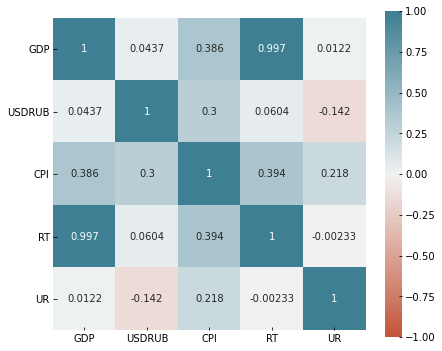

In [40]:
fig = plt.figure(figsize=(7, 6))

ax = sns.heatmap(stationary_macroeconomic_indicators.corr(),
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True, annot=True, fmt='.3g')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation=0,
                   horizontalalignment='right');

plt.show()

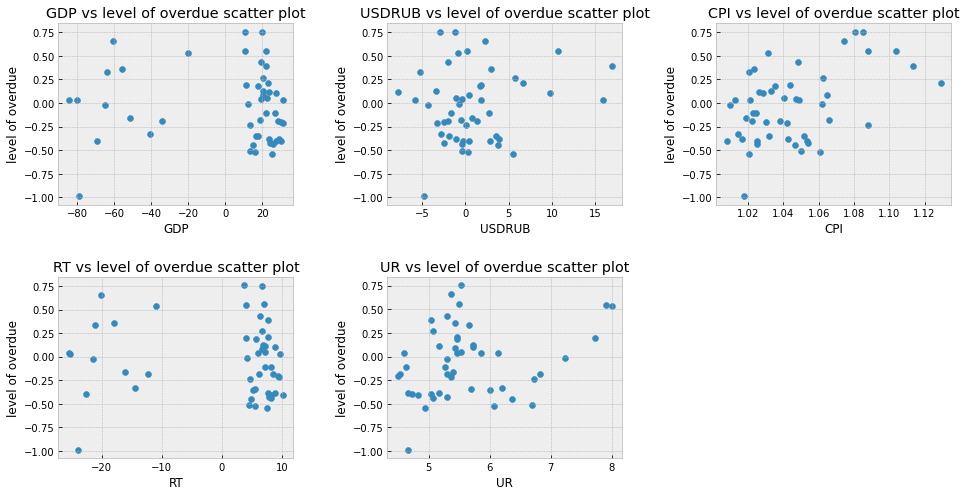

In [41]:
# Scatter plots уровня просроченности и стационарных макропоказателей
# В целом, визуально, никаких зависимостей или корреляций между уровнем просроченности и макропоказателями
fig = plt.figure(figsize=(16, 8))

plt.subplots_adjust(wspace=0.4, hspace=0.4)
for i, column in enumerate(stationary_macroeconomic_indicators.columns):
    plt.subplot(2, 3, 1+i)
    plt.scatter(stationary_macroeconomic_indicators[column][1:-5],
                stationary_level_of_overdue)
    plt.xlabel(column)
    plt.ylabel('level of overdue')
    plt.title(column + ' vs level of overdue scatter plot')
    
plt.show()

### Регрессионный анализ

In [42]:
def polynomial_regressor(X, y, degrees, lag=0):
    '''
    X - одномерный фактор регрессии (стационарный макропоказатель)
    y - регрессируемая зависимая переменная (уровень просроченной задолжности)
    degrees - int или list(of ints) - показатели степени регрессионного анализа
    (degree = 1 - линейный регрессионный анализ)
    lag - лаг между зависимой и независимой переменными
    
    Функция проводит полиномиальную регрессию для степеней degrees,
    рассчитывает показатель R^2 и визуализирует результаты
    '''
    
    xlabel = X.name + ' stationary data'
    ylabel = y.iloc[:, 0].name + ' stationary data'
    
    first_not_nan = max(X.dropna().index[0], y.dropna().index[0])

    X = X.loc[first_not_nan:]
    y = y.loc[first_not_nan:]

    last_not_nan = min(X.index[-1], y.index[-1])

    X = X.loc[:last_not_nan]
    y = y.loc[:last_not_nan]
    
    if lag > 0:
        X = np.array(X)[:-lag].reshape(-1, 1)
        y = np.array(y)[lag:].reshape(-1, 1)
    elif lag < 0:
        X = np.array(X)[abs(lag):].reshape(-1, 1)
        y = np.array(y)[:-abs(lag)].reshape(-1, 1)  
    else:
        X = np.array(X).reshape(-1, 1)
        y = np.array(y).reshape(-1, 1)  
        
    plt.scatter(X, y, label='data points')
    
    colors = ['red', 'green', 'orange', 'blue', 'yellow']
    
    for i, d in enumerate(degrees):
        polynomial_features = PolynomialFeatures(degree=d).fit_transform(X)

        X_fit = np.linspace(X.min(), X.max(), 50).reshape(-1, 1)

        regr = LinearRegression()
        regr = regr.fit(polynomial_features, y)

        y_fit = regr.predict(PolynomialFeatures(degree=d).fit_transform(X_fit))
        r2 = r2_score(y, regr.predict(polynomial_features))

        plt.plot(X_fit, y_fit, lw=2, linestyle='--', color=colors[i % len(degrees)],
                 label='Polynomial regression \n$d={:.0f}$,  $R^2={:.2f}$,  $lag={:.0f}$'.format(d, r2, lag))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend(bbox_to_anchor=(1, 1))

Lag between stationary level of overdue data and stationary macroeconomic indicators data is -1 quartal


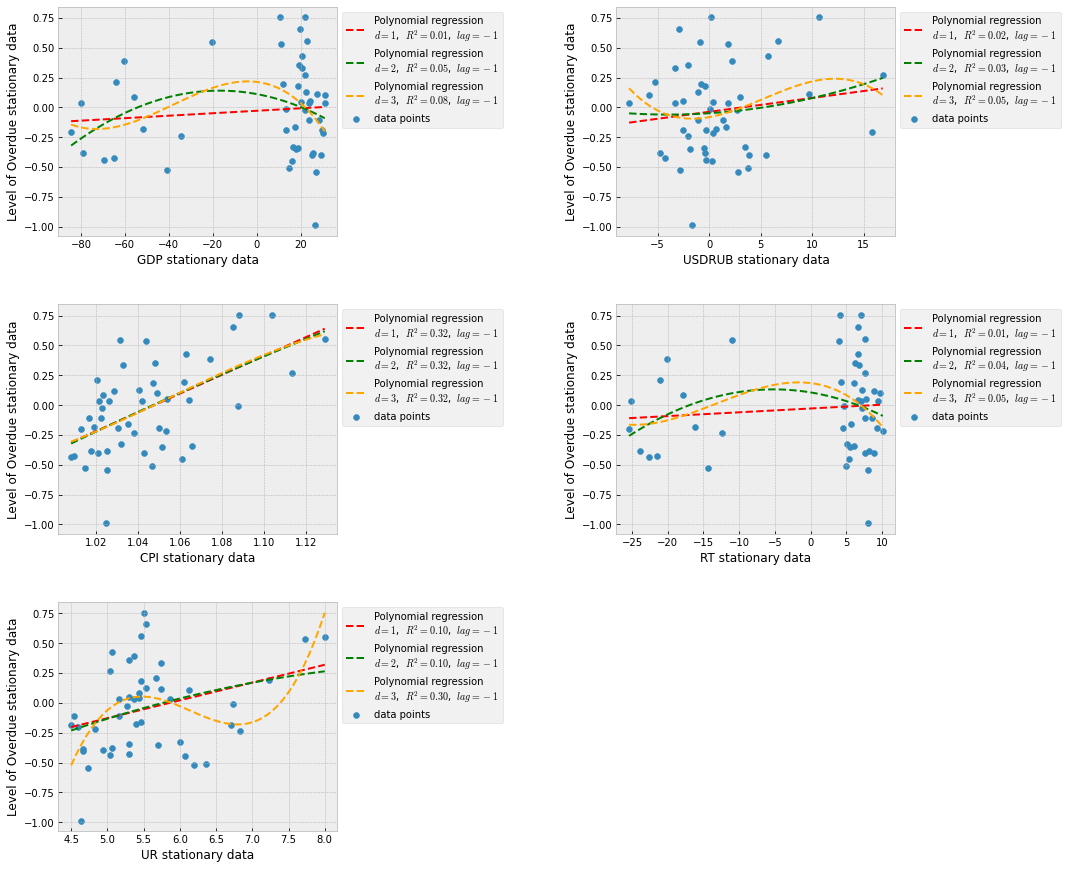



Lag between stationary level of overdue data and stationary macroeconomic indicators data is 0 quartal


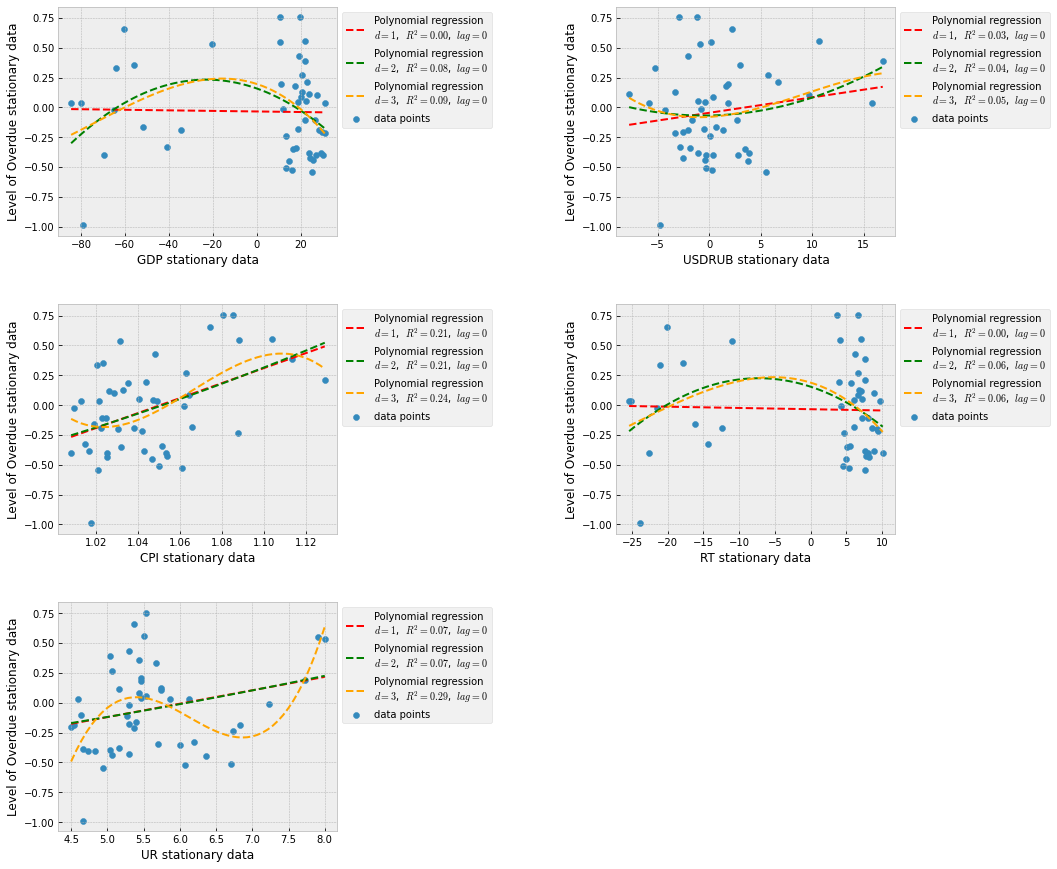



Lag between stationary level of overdue data and stationary macroeconomic indicators data is 1 quartal


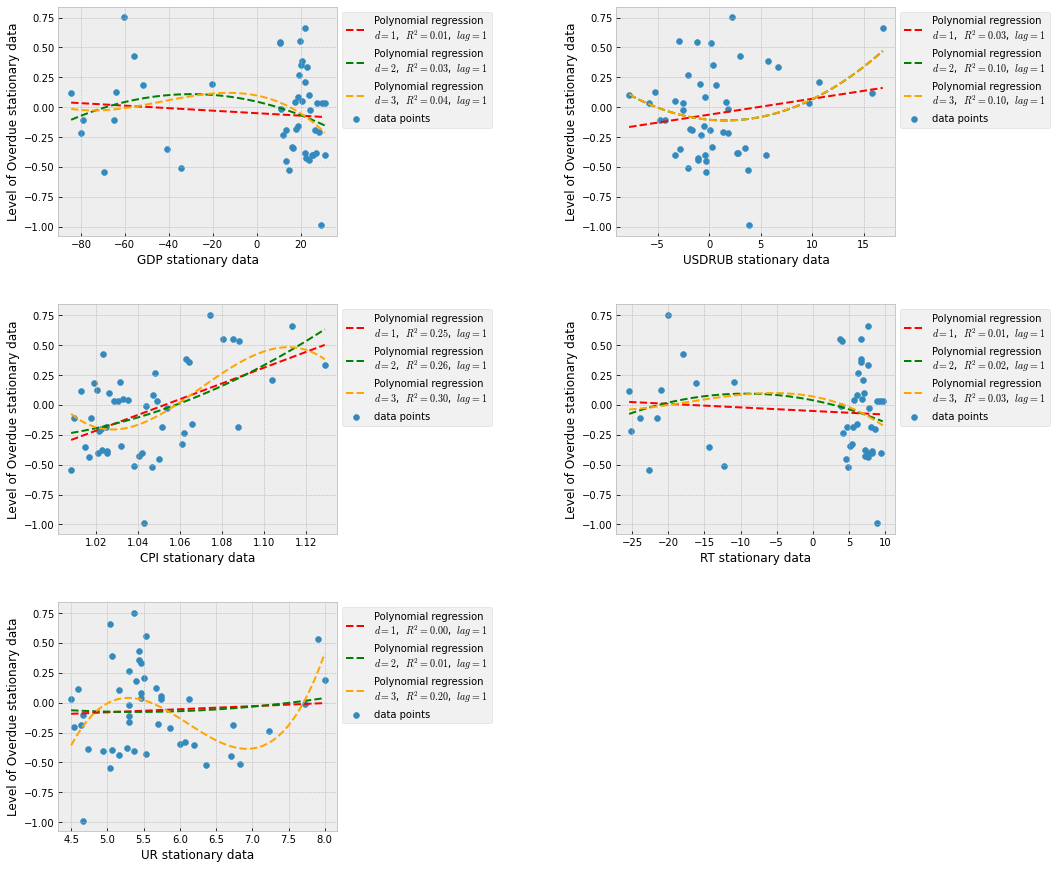

In [43]:
# В качестве примера регрессионный анализ уровня просроченной задолжности со всеми макропоказателями;
# Реализованы полиномиальные регрессии степени [1, 2, 3] при лагах между данными в [-1, 0, 1] квартал
for lag in [-1, 0, 1]:
    print(f'Lag between stationary level of overdue data and stationary macroeconomic indicators data is {lag} quartal')
    
    fig = plt.figure(figsize=(15, 300))
    
    plt.subplots_adjust(wspace=1, hspace=0.3)
    for i, indicator in enumerate(stationary_macroeconomic_indicators):
        plt.subplot(len(stationary_macroeconomic_indicators), 2, 1+i)
        polynomial_regressor(stationary_macroeconomic_indicators[indicator],
                             stationary_level_of_overdue, degrees=[1, 2, 3], lag=lag)
    plt.show()

    print('\n')
    
# Пробовал разные преобразования, разные лаги, но R^2 не превышал 0.4, оставаясь в среднем в районе 0.1    
